Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.


**План по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import RandomState
from tqdm import notebook
import re
from nltk.corpus import stopwords
import nltk

import torch
import transformers

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import shuffle

import lightgbm as lgb

state = RandomState(12345)

## Подготовка

In [2]:
comments = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0])
comments = comments.sample(1000, random_state=state).reset_index(drop=True)

Text(0.5, 1, 'Распределение целевого признака')

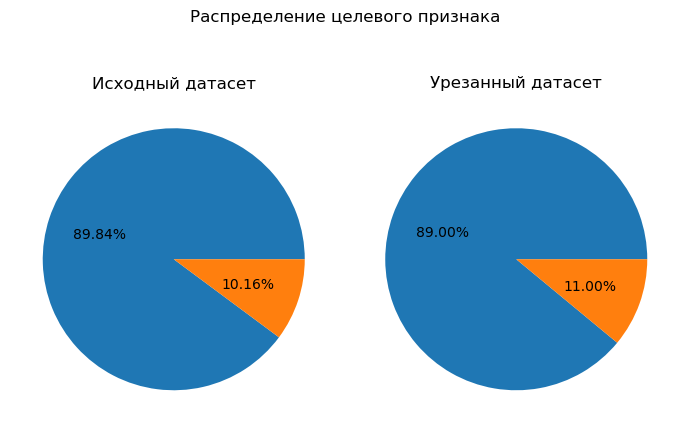

In [3]:
source_distr = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')['toxic'].value_counts()
comments_distr = comments['toxic'].value_counts()
fig, ax = plt.subplots(1, 2, figsize=(7, 5))

ax[0].pie(source_distr, autopct='%.2f%%')
ax[0].set_title("Исходный датасет")

ax[1].pie(comments_distr, autopct='%.2f%%')
ax[1].set_title("Урезанный датасет")

plt.tight_layout()
plt.suptitle('Распределение целевого признака', y=1, fontsize=12)

<span style=color:blue>**Импортируем наши данные, обрежем датасет для ускорения ембединга и обучения моделей, убедимся что целевой признак в равном соотношении с исходными данными**

In [4]:
comments['text'] = comments['text'].apply(lambda x:  " ".join(re.sub(r'[^a-zA-Z]', " ", x).split())).str.lower()
comments[:5]

,text,toxic
0,expert categorizers why is there no mention of...,0
1,noise fart talk,1
2,an indefinite block is appropriate even for a ...,0
3,i don t understand why we have a screenshot of...,0
4,hello some of the people places or things you ...,0


In [43]:
#Загружаем корпус для токенизации и модель
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
#Токенизируем данные
tokens = comments['text'].apply(lambda x: tokenizer.encode(
    x,
    add_special_tokens=True,
    retrun_token_type_ids=False,
    max_length=512,
    padding='max_length',
    return_attention_mask=True,
    return_tensort='pt'))

In [23]:
max_len = 0
for i in tokens.values:
    if len(i) > max_len:
        max_len = len(i)
print(f'Максимальная длина текста {max_len}')


#Выравниваем текста и делаем маску для игнорирования лишних элементов
padded = np.array([i + [0]*(max_len - len(i)) for i in tokens.values])
attention_mask = np.where(padded != 0, 1, 0)

Максимальная длина текста 174


In [46]:
%%time
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())
        
features = np.concatenate(embeddings)

  0%|          | 0/10 [00:00<?, ?it/s]

Wall time: 2h 7min 10s


<span style=color:blue>**Избавимся он лишних символом для точной токенизации текстов, импортируем BERT модель и сформируем вектора для обучения моделей**

In [47]:
target = comments['toxic']
features = pd.DataFrame(features)
x_train, x_test, y_train, y_test = train_test_split(
                                            features, target, test_size=0.25, stratify=target)

<span style=color:blue>**Применим `stratify` метод для сохранения исходного отношения целевого признака в тестовой и обучающей выборках**

## Обучение

In [51]:
kf = KFold(n_splits=5, shuffle=False)

### Random Forest

In [60]:
%%time
param_set = {
    'class_weight': ['balanced'],
    'n_estimators': np.arange(10, 50, 10),
    'min_samples_split': np.arange(10, 50, 10),
    'max_features': np.arange(10, 50, 10),
    'max_depth': np.arange(2, 11)
}

model = RandomForestClassifier(random_state=state)

grid_search = GridSearchCV(
                estimator = model,
                param_grid = param_set,
                scoring='f1',
                cv=kf,
                verbose=10,
                n_jobs=-1)

grid_search.fit(x_train, y_train)

rf_model = grid_search.best_estimator_
rf_f1_score = grid_search.best_score_
rf_params = grid_search.best_params_

print(f'Лучшая F1 мера модели RandomForest: {round(rf_f1_score, 2)}')
print(f'Лучшие параметеры:')
for param, value in rf_params.items():
    print(f'{param}: {value}')

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Лучшая F1 мера модели RandomForest: 0.93
Лучшие параметеры:
class_weight: balanced
max_depth: 8
max_features: 10
min_samples_split: 10
n_estimators: 40
Wall time: 26.4 s


### Logistic Regression

In [55]:
%%time
param_set = {
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': np.arange(10, 110, 10),
    'C': np.logspace(-2, 3, 100)
}

model = LogisticRegression(random_state=state)

grid_search = GridSearchCV(
                estimator = model,
                param_grid = param_set,
                scoring='f1',
                cv=kf,
                verbose=10,
                n_jobs=-1)

grid_search.fit(x_train, y_train)

lr_model = grid_search.best_estimator_
lr_f1_score = grid_search.best_score_
lr_params = grid_search.best_params_

print(f'Лучшая F1 мера модели LogisticRegression: {round(lr_f1_score, 2)}')
print(f'Лучшие параметеры:')
for param, value in lr_params.items():
    print(f'{param}: {value}')

Fitting 5 folds for each of 4000 candidates, totalling 20000 fits
Лучшая F1 мера модели LogisticRegression: 0.9
Лучшие параметеры:
C: 21.544346900318846
class_weight: balanced
max_iter: 20
penalty: l1
solver: liblinear
Wall time: 2min 59s


C:\Users\tirob\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5000 fits failed out of a total of 20000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5000 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tirob\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tirob\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\tirob\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueErro

### LightGBM

In [57]:
%%time
param_set = {
    'class_weight': ['balanced'],
    'objective': ['binary'],
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': np.arange(10, 110, 10),
    'learning_rate': [0.03, 0.1, 0.15],    
    'max_depth': np.arange(5, 10)
}

model = lgb.LGBMClassifier(random_state=state)

grid_search = GridSearchCV(
                estimator = model,
                param_grid = param_set,
                scoring='f1',
                cv=kf,
                verbose=10,
                n_jobs=-1)

grid_search.fit(x_train, y_train)

lgb_model = grid_search.best_estimator_
lgb_f1_score = grid_search.best_score_
lgb_params = grid_search.best_params_

print(f'Лучшая F1 мера модели LGBMClassifier: {round(lgb_f1_score, 2)}')
print(f'Лучшие параметеры:')
for param, value in lgb_params.items():
    print(f'{param}: {value}')

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Лучшая F1 мера модели LGBMClassifier: 0.9
Лучшие параметеры:
boosting_type: gbdt
class_weight: balanced
learning_rate: 0.15
max_depth: 5
num_leaves: 20
objective: binary
Wall time: 8min 20s


## Тестирование

### Random Forest

In [62]:
f1 = f1_score(rf_model.predict(x_test), y_test)
print(f'F1 мера модели RandomForest на тестовой выборке: {round(f1,2)}')

F1 мера модели RandomForest на тестовой выборке: 0.96


## Выводы

Text(113.9222222222222, 0.5, 'Настоящее значение')

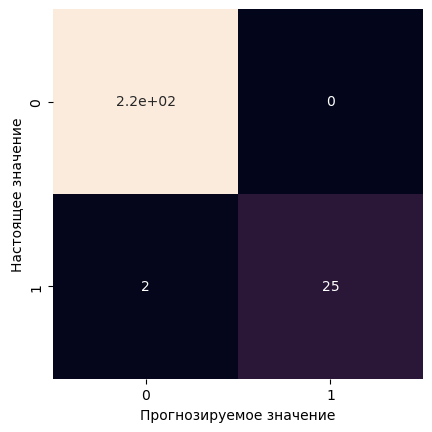

In [73]:
mat  = confusion_matrix(y_test, rf_model.predict(x_test))
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel("Прогнозируемое значение")
plt.ylabel("Настоящее значение")

<span style=color:blue>**В ходе решения задачи были выполненые следующие шаги: <br /> <br />
    - Выбор функции ошибки - F1, для определения насколько качественно модель может находить редкий класс\
    - Обработка текста, а именно - отсечение лишних символов и приведение к общему строковому виду\
    - Векторизация текста готовой BERT моделью для последующего предсказывания комментариев\
    - Обучение и подбор параметров для оптимизациии модели<br /> <br />
Итог: модель RandomForest, F1 мера составила 0.96. Модель чуть не предсказыват токсичные комменты, но при этом лишний раз не выставляет коментарии за негативные, которые таковыми не являются** </span>